Class = 3, Train points = 30, Test points = 90

In [3]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Number of classes
nn = 3
dataset_name = 'blobs_3_classes'

# Load data and preprocess
n_samples = nn*40
X, y = make_blobs(n_samples=n_samples, centers=nn, random_state=42)

# Initialize the lists to hold the split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Splitting the data
for i in range(nn):
    # Filter the data for the current class
    X_class = X[y == i]
    y_class = y[y == i]
    
    # Perform the split
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
        X_class, y_class, test_size=30, train_size=10, random_state=151
    )
    
    # Append the current class's split to the lists
    X_train_list.append(X_class_train)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class_train)
    y_test_list.append(y_class_test)

# Concatenate all class splits together
X_train = preprocessing.scale(np.concatenate(X_train_list))
X_test = preprocessing.scale(np.concatenate(X_test_list))
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f'Dataset split summary:')
print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

Dataset split summary:
Training set size: 30
Testing set size: 90


SVM training using SMO algorithm - START
Training summary: 119 iterations, 10 support vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 157 iterations, 8 support vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 152 iterations, 11 support vectors
SVM training using SMO algorithm - DONE!
train accuracy :  100.0
test accuracy :  100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



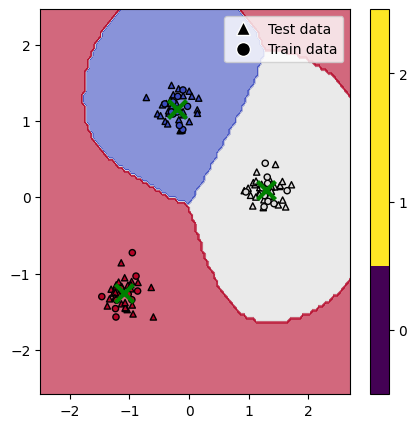

In [14]:
from sklearn.metrics import classification_report, accuracy_score
from smo_svm import smo_SVM, smo_OneVsAllClassifier
from utils import *

B = 2
K = 2
gamma = 1
C = np.sum(B ** np.arange(K))

# Train Multiclass SVM on classic optimizer
smo_solver = smo_OneVsAllClassifier(
    solver=smo_SVM,
    num_classes=nn,
    c=C,
    kkt_thr=1e-2,
    max_iter=1e3,
    kernel_type='rbf',
    gamma_rbf=gamma
)

smo_solver.fit(X_train, y_train)

# Predict
y_pred = smo_solver.predict(X_test)
yt_pred= smo_solver.predict(X_train)

# Performance analysis
smo_test_accuracy = accuracy_score(y_test, y_pred)*100
smo_train_accuracy = accuracy_score(y_train, yt_pred)*100
print("train accuracy : ", smo_train_accuracy)
print("test accuracy : ", smo_test_accuracy)

print(classification_report(y_test, y_pred))

plot_figure(smo_solver, preprocessing.scale(X), y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SMO")

Training classifier 0...
intercept :  -0.41985132655220425
Training classifier 1...
intercept :  -0.389690018613722
Training classifier 2...
intercept :  -0.2993780712260193
--------------------------------
SA
train accuracy :  [100.0]
test accuracy :  [100.0]
--------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



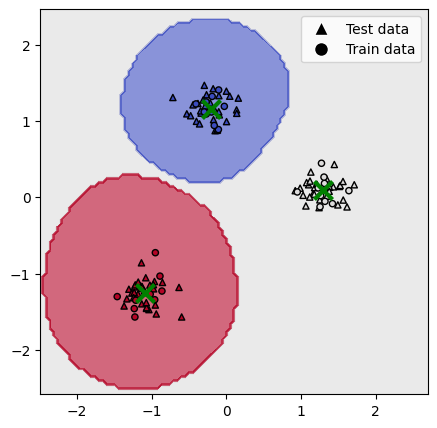

In [13]:
from sklearn.metrics import classification_report, accuracy_score
from mtqa_qsvm import qSVM, OneVsRestClassifier
from neal import SimulatedAnnealingSampler as SA

gamma = 1

params = {
    "Xi": 1,
    "gamma": gamma,
    "optimizer": SA,
    "num_reads": 1000
}

sa_test = []
sa_train = []
NN = 1
for i in range(NN):
    # Initialize and train the classifier
    sa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
    sa_OvR.solve(X_train, y_train)
    
    # Predict
    sa_predict = sa_OvR.predict(X_test)
    sa_t_pred= sa_OvR.predict(X_train)

    # Performance analysis
    sa_test_accuracy = accuracy_score(y_test, sa_predict)*100
    sa_training_accuracy = accuracy_score(y_train, sa_t_pred)*100

    sa_test.append(sa_test_accuracy)
    sa_train.append(sa_training_accuracy)

print("--------------------------------")
print("SA")
print("train accuracy : ", sa_train)
# print("mean : ", np.mean(sa_train))
# print("standard deviation : ", np.std(sa_train))
print("test accuracy : ", sa_test)
# print(np.mean(sa_test))
# print(np.std(sa_test))
print("--------------------------------")

print(classification_report(y_test, sa_predict))

plot_figure(sa_OvR, preprocessing.scale(X), y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SA")


In [5]:
from mtqa_qsvm import MTQA_OneVsRestClassifier, qSVM
from utils import *
from solver_config import dwave_MTQA

NN = 1
gamma = 1
mtqa_test = []
mtqa_train = []
qa_test = []
qa_train = []
for i in range(NN):
    params = {
        "Xi": 1,
        "gamma": gamma,
        "optimizer": dwave_MTQA
    }

    # Initialize and train the classifier
    mtqa_OvR = MTQA_OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params, vis = 0)
    _, embedding_list, TotalQubo, Qubo_list = mtqa_OvR.solve(X_train, y_train)

    save_embedding(embedding_list, dataset_name)
    save_TotalQubo(TotalQubo, dataset_name)
    save_qubo_list(Qubo_list, dataset_name)

    # Predict
    mtqa_predict = mtqa_OvR.predict(X_test)
    mtqa_t_pred= mtqa_OvR.predict(X_train)

    # Performance analysis
    mtqa_test_accuracy = accuracy_score(y_test, mtqa_predict)*100
    mtqa_training_accuracy = accuracy_score(y_train, mtqa_t_pred)*100

    mtqa_test.append(mtqa_test_accuracy)
    mtqa_train.append(mtqa_training_accuracy)

print("--------------------------------")
print("MTQA")
print("train accuracy : ", mtqa_train)
# print("mean : ", np.mean(mtqa_train))
# print("standard deviation : ", np.std(mtqa_train))
print("test accuracy : ", mtqa_test)
# print("mean : ",np.mean(mtqa_test))
# print("standard deviation : ",np.std(mtqa_test))
print("--------------------------------")

print(classification_report(y_test, mtqa_predict))

plot_figure(mtqa_OvR, preprocessing.scale(X), y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_MTQA")

intercept :  0.7998262835401011
intercept :  0.025282035833618197
intercept :  0.4083538046030339
--------------------------------
MTQA
train accuracy :  [100.0]
test accuracy :  [100.0]
--------------------------------


NameError: name 'sa_predict' is not defined

Training classifier 0...
intercept :  0.4472682106508718
Training classifier 1...
intercept :  0.3146092735505399
Training classifier 2...
intercept :  0.8421063726759868
-------------------------
QA
train accuracy :  [100.0]
test accuracy :  [100.0]
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



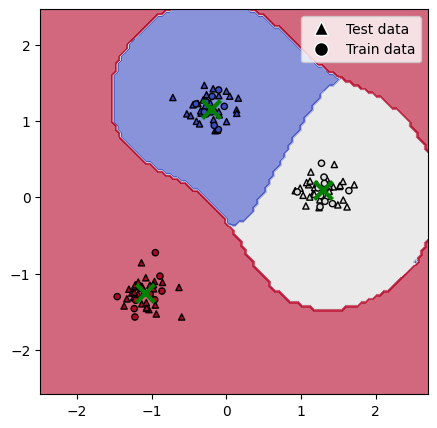

In [7]:
from mtqa_qsvm import *
from utils import *
from solver_config import dwave_QA
    
qubo_list = load_qubo_list(dataset_name)
emb = load_embedding(dataset_name)

gamma = 1
params = {
    "Xi": 1,
    "gamma": gamma,
    "optimizer": dwave_QA,
    "annealing_time": 100,
    "qubo_list" : qubo_list,
    "embeddings" : emb,
    "vis" : 0
}

# Initialize and train the classifier
qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
qa_OvR.solve(X_train, y_train)

qa_test = []
qa_train = []

# Predict
qa_predict = qa_OvR.predict(X_test)
qa_t_pred= qa_OvR.predict(X_train)

# Performance analysis
qa_test_accuracy = accuracy_score(y_test, qa_predict)*100
qa_training_accuracy = accuracy_score(y_train, qa_t_pred)*100

qa_test.append(qa_test_accuracy)
qa_train.append(qa_training_accuracy)

print("-------------------------")
print("QA")
print("train accuracy : ", qa_train)
# print("mean : ", np.mean(qa_train))
# print("standard deviation : ", np.std(qa_train))
print("test accuracy : ", qa_test)
# print(np.mean(qa_test))
# print(np.std(qa_test))
print("-------------------------")

print(classification_report(y_test, qa_predict))

plot_figure(qa_OvR, preprocessing.scale(X), y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_QA")